In [1]:
#r2py set-up
#!pip install anndata2ri
import anndata2ri
import rpy2.rinterface_lib.callbacks
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np

# Activate the anndata2ri conversion between singlecellExperiment and Anndata
anndata2ri.activate()

# Activate the rpy2 extension enables cell magic to be used. This runs R code in jupyter notebook cells
%load_ext rpy2.ipython

/tmp/ipykernel_3676623/1200544146.py:10: DeprecationWarning: The global conversion available with activate() is deprecated and will be removed in the next major release. Use a local converter.
  anndata2ri.activate()


In [3]:
%%R
packageVersion("miloR")

[1] ‘2.0.0’


In [4]:
%%R
library(miloR)
library(igraph)
library(ggplot2)

Loading required package: edgeR
Loading required package: limma

Attaching package: ‘igraph’

The following object is masked from ‘package:miloR’:

    graph

The following objects are masked from ‘package:stats’:

    decompose, spectrum

The following object is masked from ‘package:base’:

    union



In [ ]:
sc.set_figure_params(dpi=300, figsize=(5,5))
adata = sc.read_h5ad('/data/project/AI4Omic/MASLD/results/scRNA/preprocessing/adata_Mono&DC_29samples.h5ad')
#adata = sc.read_h5ad('/data/project/AI4Omic/MASLD/results/scRNA/VDJ/adata_tcr_prescirpy_29samples.h5ad')
#adata = sc.read_h5ad('/data/project/AI4Omic/MASLD/results/scRNA/VDJ/adata_bcr_prescirpy_29samples.h5ad')
#adata.obs['disease_status'] = adata.obs['disease_status'].cat.reorder_categories(['CTRL', 'MASL', 'MASH'])

In [125]:
# For comparison between CTRL and MASLD (MASL and MASH)
adata.obs.disease_status = adata.obs.disease_status.replace({'MASH': 'MASLD', 'MASL': 'MASLD'})
adata.obs.disease_status = adata.obs.disease_status.cat.reorder_categories(['CTRL', 'MASLD'])

/tmp/ipykernel_86306/272412699.py:2: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  adata.obs.disease_status = adata.obs.disease_status.replace({'MASH': 'MASLD', 'MASL': 'MASLD'})


In [ ]:
# For comparison between MASH and MASL
adata = adata[adata.obs.disease_status.isin(['MASL', 'MASH'])].copy()
sc.pl.umap(adata, color=['disease_status'], legend_loc='on data')

In [141]:
adata.layers['logcounts'] = adata.X.copy()
adata_no_knn = adata.copy()
adata_no_knn.obsp = None
adata_no_knn.uns.pop('neighbors')

/tmp/ipykernel_86306/3111056352.py:1: ImplicitModificationWarning: Setting element `.layers['logcounts']` of view, initializing view as actual.
  adata.layers['logcounts'] = adata.X.copy()


{'connectivities_key': 'connectivities',
 'distances_key': 'distances',
 'params': {'method': 'umap',
  'metric': 'euclidean',
  'n_neighbors': 30,
  'n_pcs': 30,
  'random_state': 0,
  'use_rep': 'X_pca_harmony'}}

In [142]:
knn_adjacency = adata.obsp['connectivities'].copy()

In [143]:
%%R -i adata_no_knn
milo <- Milo(adata_no_knn)
milo

class: Milo 
dim: 34744 14424 
metadata(11): cell_type_lvl1_colors cell_type_lvl2_colors ... scrublet
  umap
assays(3): X counts logcounts
rownames(34744): A1BG A1BG-AS1 ... ZYX ZZEF1
rowData names(6): highly_variable highly_variable_rank ...
  variances_norm highly_variable_nbatches
colnames(14424): CTRL-173-Hepa_AACACACAGAATCCGGTGTTAAGAGGC
  CTRL-173-Hepa_AACACCGTTTGAGGCCTTCTGTACACA ...
  MASH-2134_TTCACGCACAACCACATCTTCACA MASH-2134_TTCACGCACCGACAACCTAAGGTC
colData names(35): sample disease_status ... cell_type_lvl1
  cell_type_lvl2
reducedDimNames(3): PCA X_pca_harmony UMAP
mainExpName: NULL
altExpNames(0):
nhoods dimensions(2): 1 1
nhoodCounts dimensions(2): 1 1
nhoodDistances dimension(1): 0
graph names(0):
nhoodIndex names(1): 0
nhoodExpression dimension(2): 1 1
nhoodReducedDim names(0):
nhoodGraph names(0):
nhoodAdjacency dimension(2): 1 1


In [144]:
%%R -i knn_adjacency
milo_graph <- buildFromAdjacency(knn_adjacency, k=30, is.binary=TRUE, d=30)
graph(milo) <- miloR::graph(milo_graph)

In [145]:
%%R
milo <- buildGraph(milo, k=30, d=30, reduced.dim='X_pca_harmony')

Constructing kNN graph with k:30


In [108]:
%%R
levels(milo$disease_status)

[1] "MASL" "MASH"


In [146]:
# Run Milo analysis
design_df = adata.obs[['orig.ident', 'Centrifugation', 'disease_status']]
design_df.index = design_df['orig.ident']
design_df.drop_duplicates(inplace=True)

# reoder categories
design_df['disease_status'] = design_df['disease_status'].astype('category')
design_df['disease_status'] = design_df['disease_status'].cat.reorder_categories(['CTRL', 'MASLD'])
#design_df['disease_status'] = design_df['disease_status'].cat.reorder_categories(['MASL', 'MASH'])
design_df

/tmp/ipykernel_86306/192833729.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  design_df.drop_duplicates(inplace=True)
/tmp/ipykernel_86306/192833729.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  design_df['disease_status'] = design_df['disease_status'].astype('category')
/tmp/ipykernel_86306/192833729.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexi

,orig.ident,Centrifugation,disease_status
orig.ident,,,
CTRL-173-Hepa,CTRL-173-Hepa,PCs,CTRL
CTRL-175-Hepa,CTRL-175-Hepa,PCs,CTRL
CTRL-371-Hepa,CTRL-371-Hepa,PCs,CTRL
MASLD-1500-Hepa,MASLD-1500-Hepa,PCs,MASLD
MASLD-1483-Hepa,MASLD-1483-Hepa,PCs,MASLD
MASLD-1514-Hepa,MASLD-1514-Hepa,PCs,MASLD
MASLD-1504-Hepa,MASLD-1504-Hepa,PCs,MASLD
MASLD-8720-Hepa,MASLD-8720-Hepa,PCs,MASLD
MASLD-0910-Hepa,MASLD-0910-Hepa,PCs,MASLD


In [147]:
%%R -i design_df -o DA_results

## Define representative neighbourhoods on the KNN graph
#milo@.k <- 10
milo <- makeNhoods(milo, prop=0.3, k=30, d=30, refined=TRUE, reduced_dims='X_pca_harmony')
plotNhoodSizeHist(milo)

## Count cells in neighbourhoods
milo <- countCells(milo, meta.data=data.frame(colData(milo)), sample="orig.ident")
head(nhoodCounts(milo))

## Calculate distances between cells in neighbourhoods for spatial FDR correction
milo <- calcNhoodDistance(milo, d=30, reduced.dim="X_pca_harmony")

## Test for differential abundance
#DA_results <- testNhoods(milo, design= ~ 0 + group, design.df=design_df)
DA_results <- testNhoods(milo, design= ~ Centrifugation + disease_status, design.df=design_df)

DA_results

            logFC   logCPM            F       PValue        FDR Nhood
1    -0.231627294 11.01996 3.065266e-01 5.806009e-01 0.74148208     1
2     1.322171362 10.49599 4.374022e+00 3.808810e-02 0.14695258     2
3     2.349796627 10.30396 9.479820e+00 2.462355e-03 0.03167249     3
4    -0.074641652 11.91053 2.842251e-02 8.664059e-01 0.92335843     4
5     1.458455380 10.38221 4.617438e+00 3.316906e-02 0.13552182     5
6     0.447728955 11.11763 8.879404e-01 3.475464e-01 0.55757721     6
7     2.418978424 10.93067 1.246041e+01 5.445496e-04 0.01964772     7
8     1.600759641 10.43815 5.303908e+00 2.257975e-02 0.11356946     8
9    -0.389267088 10.34221 6.542712e-01 4.198042e-01 0.61635989     9
10    1.440785103 11.39311 6.310392e+00 1.348506e-02 0.07996589    10
11    3.085767346 10.77886 1.587185e+01 1.044890e-04 0.01473132    11
12    0.886757513 11.18080 3.090131e+00 8.070190e-02 0.23110628    12
13   -0.244490372 11.08478 3.701805e-01 5.437782e-01 0.71441207    13
14   -0.801758382 11

Checking valid object
Running refined sampling with reduced_dim
Checking meta.data validity
Counting cells in neighbourhoods
Using TMM normalisation
Performing spatial FDR correction with k-distance weighting
In addition: Warning message:
In testNhoods(milo, design = ~Centrifugation + disease_status, design.df = design_df) :
  Sample names in design matrix and nhood counts are not matched. Reordering


In [148]:
%%R
milo <- buildNhoodGraph(milo)

Text(0, 0.5, '- log10(Spatial FDR)')

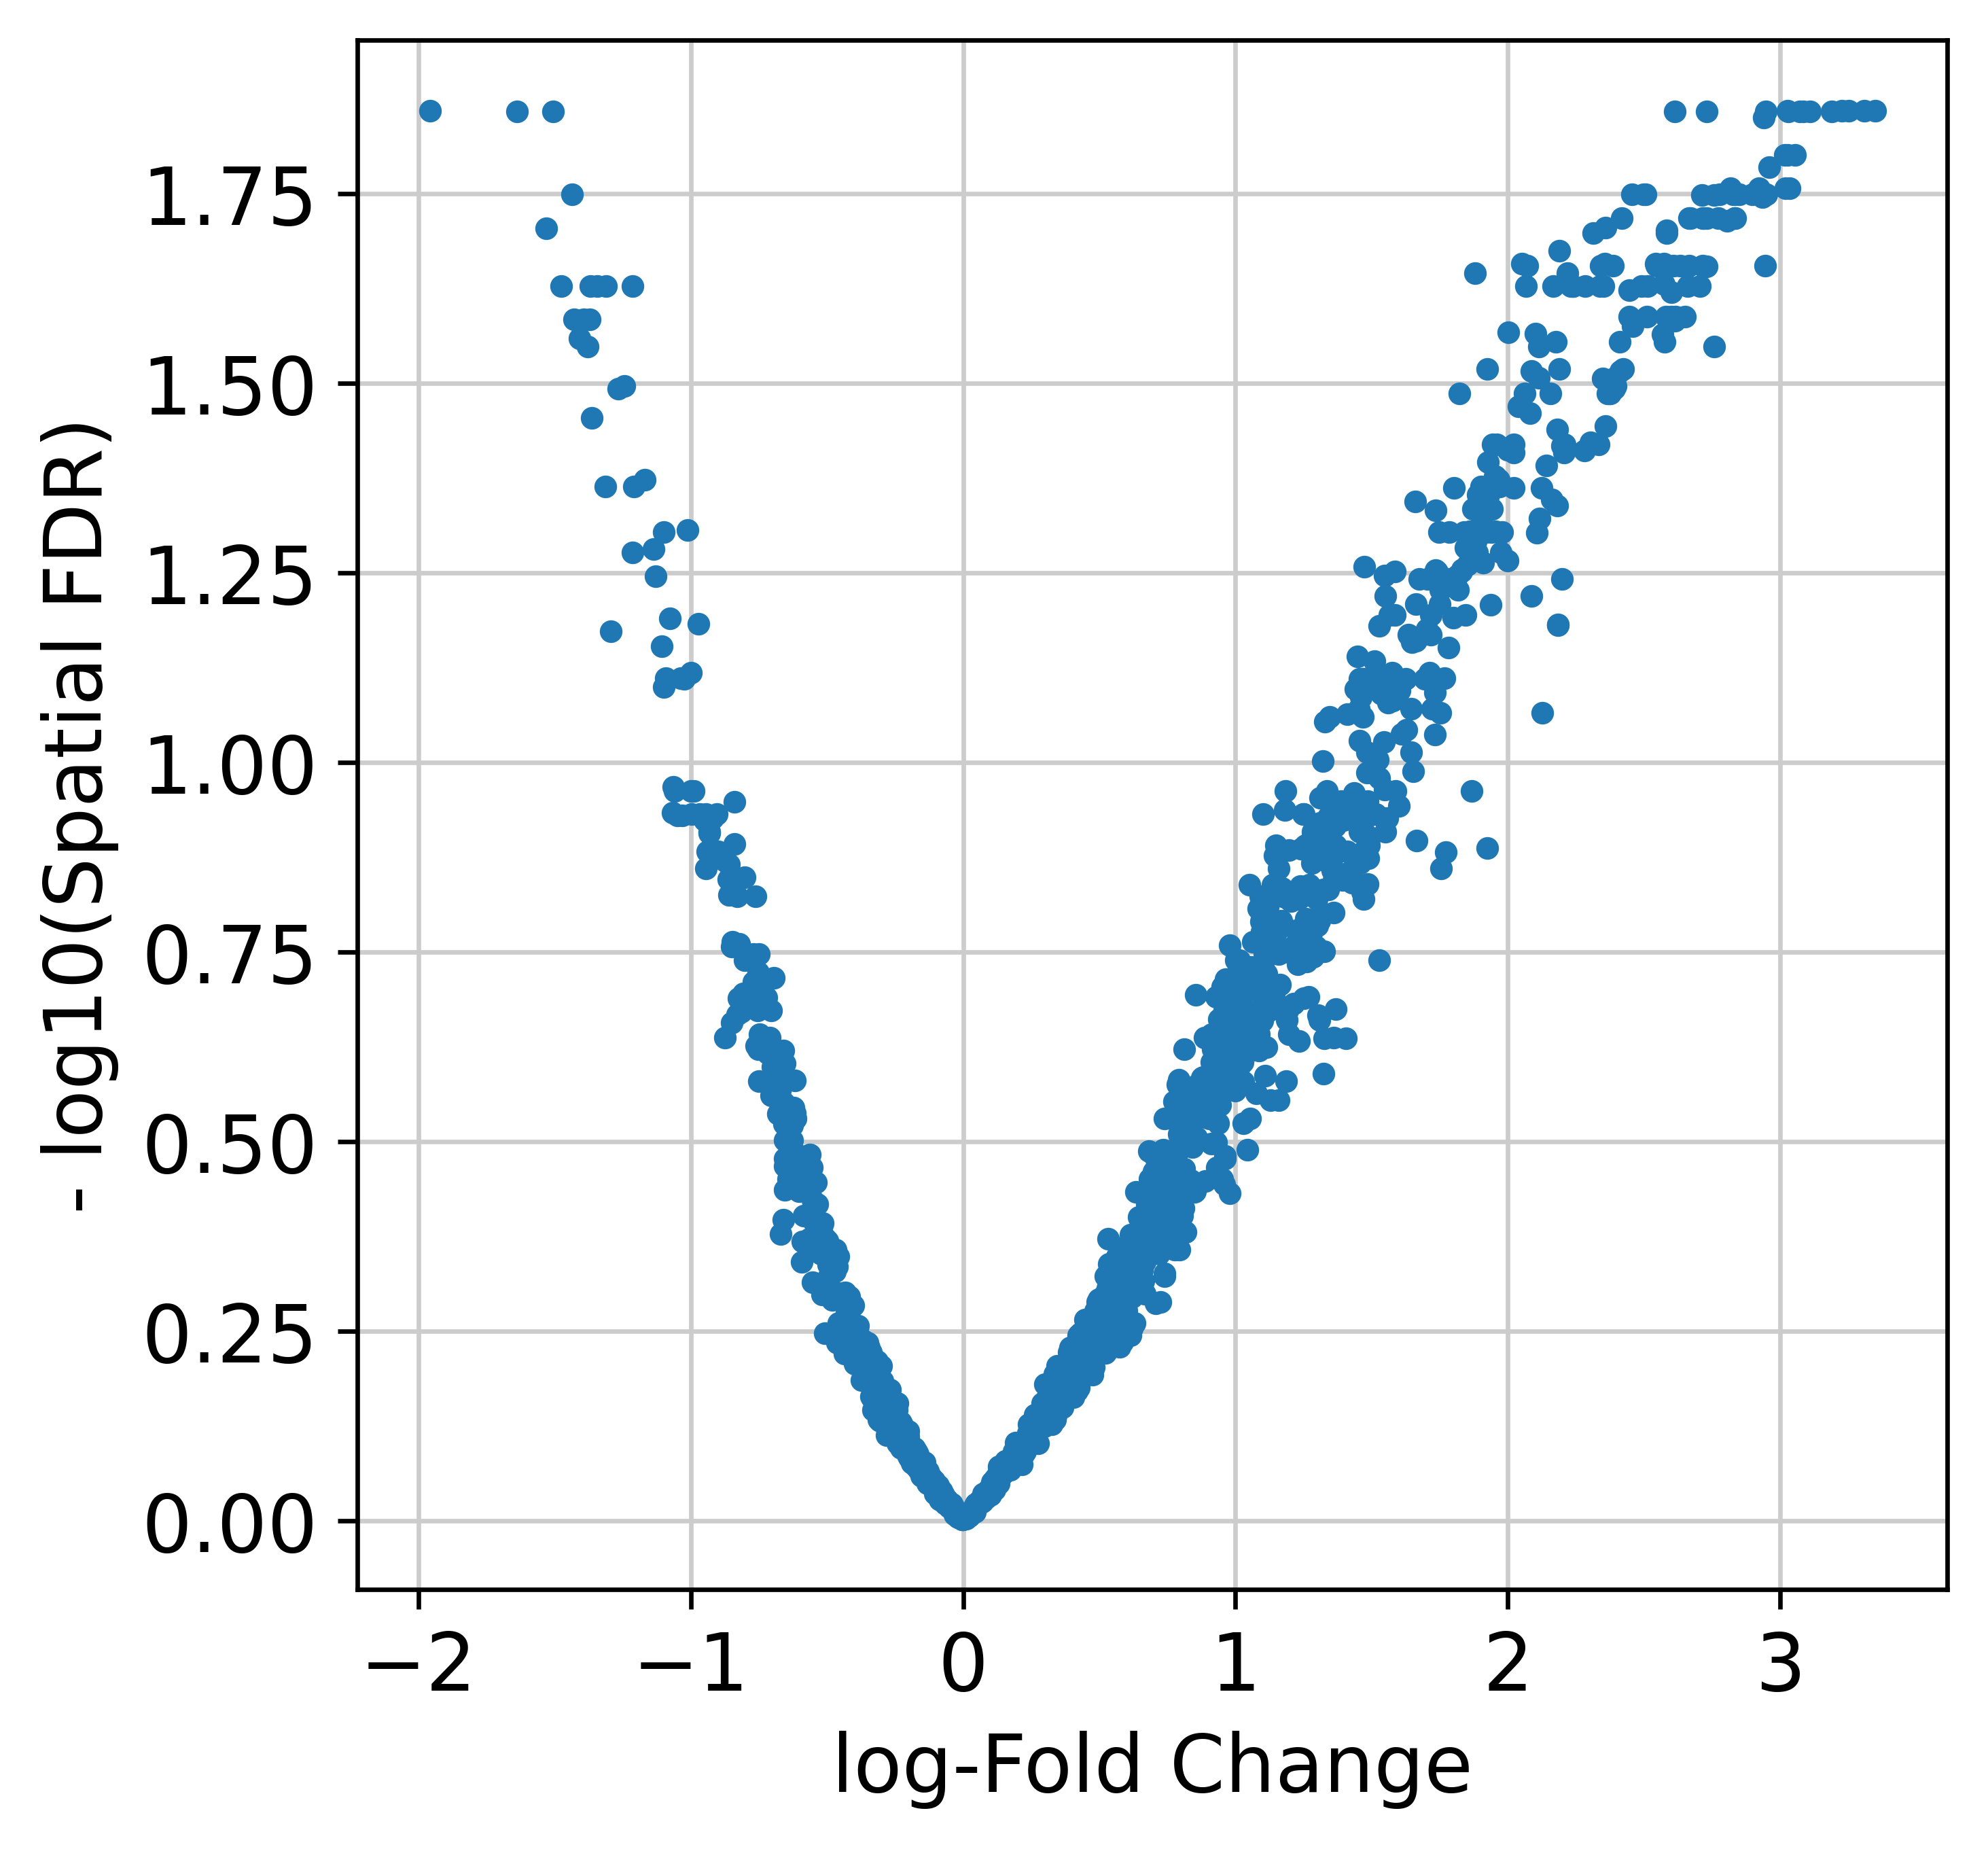

In [149]:
plt.plot(DA_results.logFC, -np.log10(DA_results.SpatialFDR), '.')
plt.xlabel("log-Fold Change")
plt.ylabel("- log10(Spatial FDR)")

In [ ]:
%%R -w 600 -h 600
plotNhoodGraphDA(milo, DA_results, alpha=0.05) + scale_fill_gradient2(low="#4E79A7", mid="white", high="#C98EE8", midpoint=0) + theme(legend.position="none") #4E79A7
#ggsave('/data/project/AI4Omic/MASLD/results/scRNA/Milo/milo_graph_Mono&DC_MASLD_CTRL.png')
#ggsave('/data/project/AI4Omic/MASLD/results/scRNA/Milo/milo_graph_Mono&DC_MASH_MASL.png')
#ggsave('/data/project/AI4Omic/MASLD/results/scRNA/Milo/milo_graph_T&NK_MASLD_CTRL.png')
#ggsave('/data/project/AI4Omic/MASLD/results/scRNA/Milo/milo_graph_T&NK_MASH_MASL.png') 
ggsave('/data/project/AI4Omic/MASLD/results/scRNA/Milo/milo_graph_B_MASLD_CTRL.png')
#ggsave('/data/project/AI4Omic/MASLD/results/scRNA/Milo/milo_graph_B_MASH_MASL.png')

Scale for fill is already present.
Adding another scale for fill, which will replace the existing scale.
Saving 8.33 x 8.33 in image


In [ ]:
%%R
#saveRDS(milo, file="/data/project/AI4Omic/MASLD/results/scRNA/Milo/milo_Mono&DC_MASH_MASL.rds")
#saveRDS(milo, file="/data/project/AI4Omic/MASLD/results/scRNA/Milo/milo_T&NK_MASLD_CTRL.rds")
#saveRDS(milo, file="/data/project/AI4Omic/MASLD/results/scRNA/Milo/milo_T&NK_MASH_MASL.rds")
#saveRDS(milo, file="/data/project/AI4Omic/MASLD/results/scRNA/Milo/milo_B_MASH_MASL.rds")
saveRDS(milo, file="/data/project/AI4Omic/MASLD/results/scRNA/Milo/milo_B_MASLD_CTRL.rds")

In [ ]:
%%R -w 1000 -h 800
DA_results <- annotateNhoods(milo, DA_results, coldata_col = 'cell_type_lvl2')
plotDAbeeswarm(DA_results, group.by='cell_type_lvl2') + scale_color_gradient2(low="#4E79A7", mid="white", high="#C98EE8", midpoint=0) + theme(legend.position="none")
#ggsave('/data/project/AI4Omic/MASLD/results/scRNA/Milo/milo_beeswarm_Mono&DC_MASLD_CTRL.pdf')
#ggsave('/data/project/AI4Omic/MASLD/results/scRNA/Milo/milo_beeswarm_Mono&DC_MASH_MASL.pdf')
#ggsave('/data/project/AI4Omic/MASLD/results/scRNA/Milo/milo_beeswarm_T&NK_MASLD_CTRL.pdf')
#ggsave('/data/project/AI4Omic/MASLD/results/scRNA/Milo/milo_beeswarm_T&NK_MASH_MASL.pdf')
ggsave('/data/project/AI4Omic/MASLD/results/scRNA/Milo/milo_beeswarm_B_MASLD_CTRL.pdf')
#ggsave('/data/project/AI4Omic/MASLD/results/scRNA/Milo/milo_beeswarm_B_MASH_MASL.pdf')

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Saving 13.9 x 11.1 in image


Converting group_by to factor...


In [ ]:
%%R
# DA_results要保存 Nhoods要知道数目
#write.csv(DA_results, '/data/project/AI4Omic/MASLD/results/scRNA/Milo/DA_results_T&NK_MASLD_CTRL.csv')
#write.csv(DA_results, '/data/project/AI4Omic/MASLD/results/scRNA/Milo/DA_results_T&NK_MASH_MASL.csv')
#write.csv(DA_results, '/data/project/AI4Omic/MASLD/results/scRNA/Milo/DA_results_Mono&DC_MASLD_CTRL.csv')
#write.csv(DA_results, '/data/project/AI4Omic/MASLD/results/scRNA/Milo/DA_results_Mono&DC_MASH_MASL.csv')
write.csv(DA_results, '/data/project/AI4Omic/MASLD/results/scRNA/Milo/DA_results_B_MASLD_CTRL.csv')
#write.csv(DA_results, '/data/project/AI4Omic/MASLD/results/scRNA/Milo/DA_results_B_MASH_MASL.csv')

In [ ]:
import pandas as pd
dfs = []
for filename in ['/data/project/AI4Omic/MASLD/results/scRNA/Milo/DA_results_Mono&DC_MASLD_CTRL.csv',
                 '/data/project/AI4Omic/MASLD/results/scRNA/Milo/DA_results_B_MASLD_CTRL.csv',
    '/data/project/AI4Omic/MASLD/results/scRNA/Milo/DA_results_T&NK_MASLD_CTRL.csv']:
    df = pd.read_csv(filename, index_col=0)
    dfs.append(df)

DA_results = pd.concat(dfs, ignore_index=True)

In [ ]:
%%R -i DA_results -w 900 -h 1100
plotDAbeeswarm(DA_results, group.by='cell_type_lvl2') + scale_color_gradient2(low="#4E79A7", mid="white", high="#C98EE8", midpoint=0) + theme(legend.position="none", panel.grid.minor=element_blank(), panel.grid.major=element_blank()) + xlab('')
ggsave('/data/project/AI4Omic/MASLD/results/scRNA/Milo/milo_beeswarm_MASLD_CTRL.pdf')

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Saving 12.5 x 15.3 in image


Converting group_by to factor...


In [ ]:
import pandas as pd
dfs = []
for filename in ['/data/project/AI4Omic/MASLD/results/scRNA/Milo/DA_results_Mono&DC_MASH_MASL.csv',
                 '/data/project/AI4Omic/MASLD/results/scRNA/Milo/DA_results_B_MASH_MASL.csv',
    '/data/project/AI4Omic/MASLD/results/scRNA/Milo/DA_results_T&NK_MASH_MASL.csv']:
    df = pd.read_csv(filename, index_col=0)
    dfs.append(df)

DA_results = pd.concat(dfs, ignore_index=True)

In [ ]:
%%R -i DA_results -w 900 -h 1100
plotDAbeeswarm(DA_results, group.by='cell_type_lvl2') + scale_color_gradient2(low="#4E79A7", mid="white", high="#C98EE8", midpoint=0) + theme(legend.position="none", panel.grid.minor=element_blank(), panel.grid.major=element_blank()) + xlab('')
ggsave('/data/project/AI4Omic/MASLD/results/scRNA/Milo/milo_beeswarm_MASH_MASL.pdf')

Scale for colour is already present.
Adding another scale for colour, which will replace the existing scale.
Saving 12.5 x 15.3 in image


Converting group_by to factor...
